# Modélisation de la prédiction de tags pour les questions de Stack Overflow

Ce notebook contient les travaux de prétraitement des documents ainsi que les tests de modèles utilisant des approches supervisées et non supervisées, dans le but de prédire les tags (étiquettes) de Stack Overflow.

Les données ont été traitées pour enlever les balises HTML, les caractères de ponctuation, les stopwords et les mots de plus de 21 caractères. L'analyse a révélé que la distribution des longueurs de titres de questions suivait une loi normale, avec une moyenne de 5 mots par titre. Le but de ce travail est de développer des modèles capables de prédire les tags les plus pertinents pour une question donnée.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from operator import itemgetter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,\
                            recall_score, f1_score, jaccard_score

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
##from skmultilearn.adapt import MLkNN
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.multioutput import ClassifierChain
from sklearn.decomposition import LatentDirichletAllocation, NMF

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

pip install --upgrade protobuf

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel

import warnings
##import spacy
warnings.filterwarnings("ignore")

# Data

In [5]:
def data_load_reshape (path):
    
    
    data = pd.read_csv(path,
                     index_col = 0,
                     na_values = 'NaN'
                    )
    
    data["Title + Body"] = data["Title T2N"] + data["Body T2N"] 
    data["Title + Body"] = data["Title + Body"].str.split()
    data["Title + Body T2N"] = data["Title T2N"].astype(str) + " " + data["Body T2N"].astype(str) 
    data["tags"] = data["Tags T2N"].str.split()
    docs = data["Title T2N"].astype(str) + " " +data["Body T2N"].astype(str)
    
    return data, docs

path = "data_clean.csv"  
data, docs = data_load_reshape(path)

In [6]:
data.head(3)

,Id,Title,Body,Tags,Title T2N,Tags T2N,Body T2N,Title_len,Body_len,Title + Body,Title + Body T2N,tags
0,41413141,"['client', 'side', 'still', 'using', 'interpre...","['knowledge', 'javascript', 'language', 'execu...","['javascript', 'optimization', 'web', 'interpr...",client side still using interpreted language,javascript optimization web interpreted-langu...,knowledge javascript language execute client ...,6,87,"[client, side, still, using, interpreted, lang...",client side still using interpreted language ...,"[javascript, optimization, web, interpreted-la..."
1,41413489,"['coroutine', 'threading', 'context', 'corouti...","['latest', 'http', 'open', 'doc', 'paper', 'ba...","['c++', 'multithreading', 'async-await', 'coro...",coroutine threading context coroutine scheduling,c++ multithreading async-await coroutine c++-...,latest http open doc paper based understandin...,5,276,"[coroutine, threading, context, coroutine, sch...",coroutine threading context coroutine schedul...,"[c++, multithreading, async-await, coroutine, ..."
2,41413544,"['calculate', 'percentile', 'long', 'array']","['given', 'long', 'array', 'latency', 'millise...","['java', 'math', 'statistic', 'apache-commons'...",calculate percentile long array,java math statistic apache-commons percentile,given long array latency millisecond want cal...,4,62,"[calculate, percentile, long, array, given, lo...",calculate percentile long array given long a...,"[java, math, statistic, apache-commons, percen..."


Les données sont converties à l'aide d'un vectorizer.

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [8]:
tfidf_vectorizer_ = TfidfVectorizer(max_features=2000)
tfidf_ = tfidf_vectorizer_.fit_transform(data["Title T2N"].astype(str) )
tfidf_feature_names_ = tfidf_vectorizer_.get_feature_names_out()

## ACP


Nous appliquons une ACP (Analyse en Composantes Principales) pour déterminer le nombre optimal de variables à utiliser dans notre vectoriseur. On crée une fonction qui transforme les données en matrice. Cetet étape nous permet juste de déterminer le nombre de colonnes qu'on souhaite utiliser.

In [9]:
def transform_vector (df, colonne, model, max_feat) :
    
    """
    df : DataFrame en entrée
    colonne : la colonne qu'on souhaite transformer
    model : le modèle utiliser
    max_feat : nombre max de features.
    """
    
    vectorizer = model (max_features = max_feat)
    df_transform = vectorizer.fit_transform(df[colonne].values.astype('U')).toarray()
    feature_names = vectorizer.get_feature_names_out()
    df_finale = pd.DataFrame(df_transform, columns=feature_names)
    
    df_finale_freq = pd.DataFrame(df_finale.sum(), columns=["Value"])
    df_finale_freq.sort_values(by=['Value'], inplace=True,ascending=False)
    
    return {"Vector Tranformed" : df_finale  , "Freq" : df_finale_freq, "Vectorizer" :vectorizer   }

In [10]:
def func_tag_filtered (nb_filtered): 
    
    df_test = transform_vector (data, "Tags",  CountVectorizer, 2000)
    df_test_tfid = transform_vector (data, "Tags",  TfidfVectorizer, 2000)

    df_test_tfid["Freq"] = df_test_tfid["Freq"].apply(lambda x : x.replace("'","") )
    tags_filtered = df_test_tfid["Freq"][:nb_filtered].index.to_list()

    df_test["Freq"] = df_test["Freq"].apply(lambda x : x.replace("'","") )
    tags_filtered_v = df_test["Freq"][:nb_filtered].index.to_list()
    
    return tags_filtered, tags_filtered_v

nb_filtered = 500
tags_filtered, tags_filtered_v = func_tag_filtered (nb_filtered)
tags_filtered[:20]

['python',
 'android',
 'java',
 'javascript',
 'net',
 'spring',
 'js',
 'io',
 'core',
 'node',
 'asp',
 'angular',
 'reactjs',
 'swift',
 'react',
 'amazon',
 'typescript',
 'google',
 'studio',
 'docker']

In [11]:
tags_filtered_v[:20]

['python',
 'android',
 'java',
 'javascript',
 'net',
 'spring',
 'js',
 'asp',
 'core',
 'io',
 'node',
 'angular',
 'reactjs',
 'amazon',
 'react',
 'google',
 'studio',
 'web',
 'docker',
 'typescript']

In [12]:
appel = transform_vector(data, "Title + Body T2N" , CountVectorizer, 5000)
data_acp = appel["Vector Tranformed"]

In [13]:
data_acp

,aapt,aarch,abcd,ability,able,abort,aborted,absolute,absolutely,abstract,...,yyyy,zero,zipfile,zlib,zone,zoneddatetime,zookeeper,zoom,zygoteinit,zypp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42106,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
from sklearn import decomposition
from sklearn import preprocessing 
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

data_slf = data_acp

## Appel de la classe PCA
pca = PCA()
pca.fit(data_slf)

PCA()

In [15]:
data_slf

,aapt,aarch,abcd,ability,able,abort,aborted,absolute,absolutely,abstract,...,yyyy,zero,zipfile,zlib,zone,zoneddatetime,zookeeper,zoom,zygoteinit,zypp
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42106,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
col = list(data_slf.columns)

In [17]:
def PCA_Func (data) : 
    
    ## Projection des PCA et choix du nombre de composant
    filtered_cols = list(data.columns)
    sel_feat =  list(data.columns)

    ## Récupération des valeurs du dataframe dans une liste
    X = data.loc[:, filtered_cols].values

    ##Sélection des colonnes
    features = data_slf.loc[:, filtered_cols].columns

    ## Choix du nombre de composantes
    n_comp = len(sel_feat)-1

    ##Normaliser les caractéristiques en supprimant la moyenne et en mettant à l'échelle la variance unitaire.
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    ##Decomposition en PCA
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(X_scaled)


    pcs = pca.components_

    X_projected = pca.transform(X_scaled)
    
    return pca

In [18]:
pca = PCA_Func (data_slf)

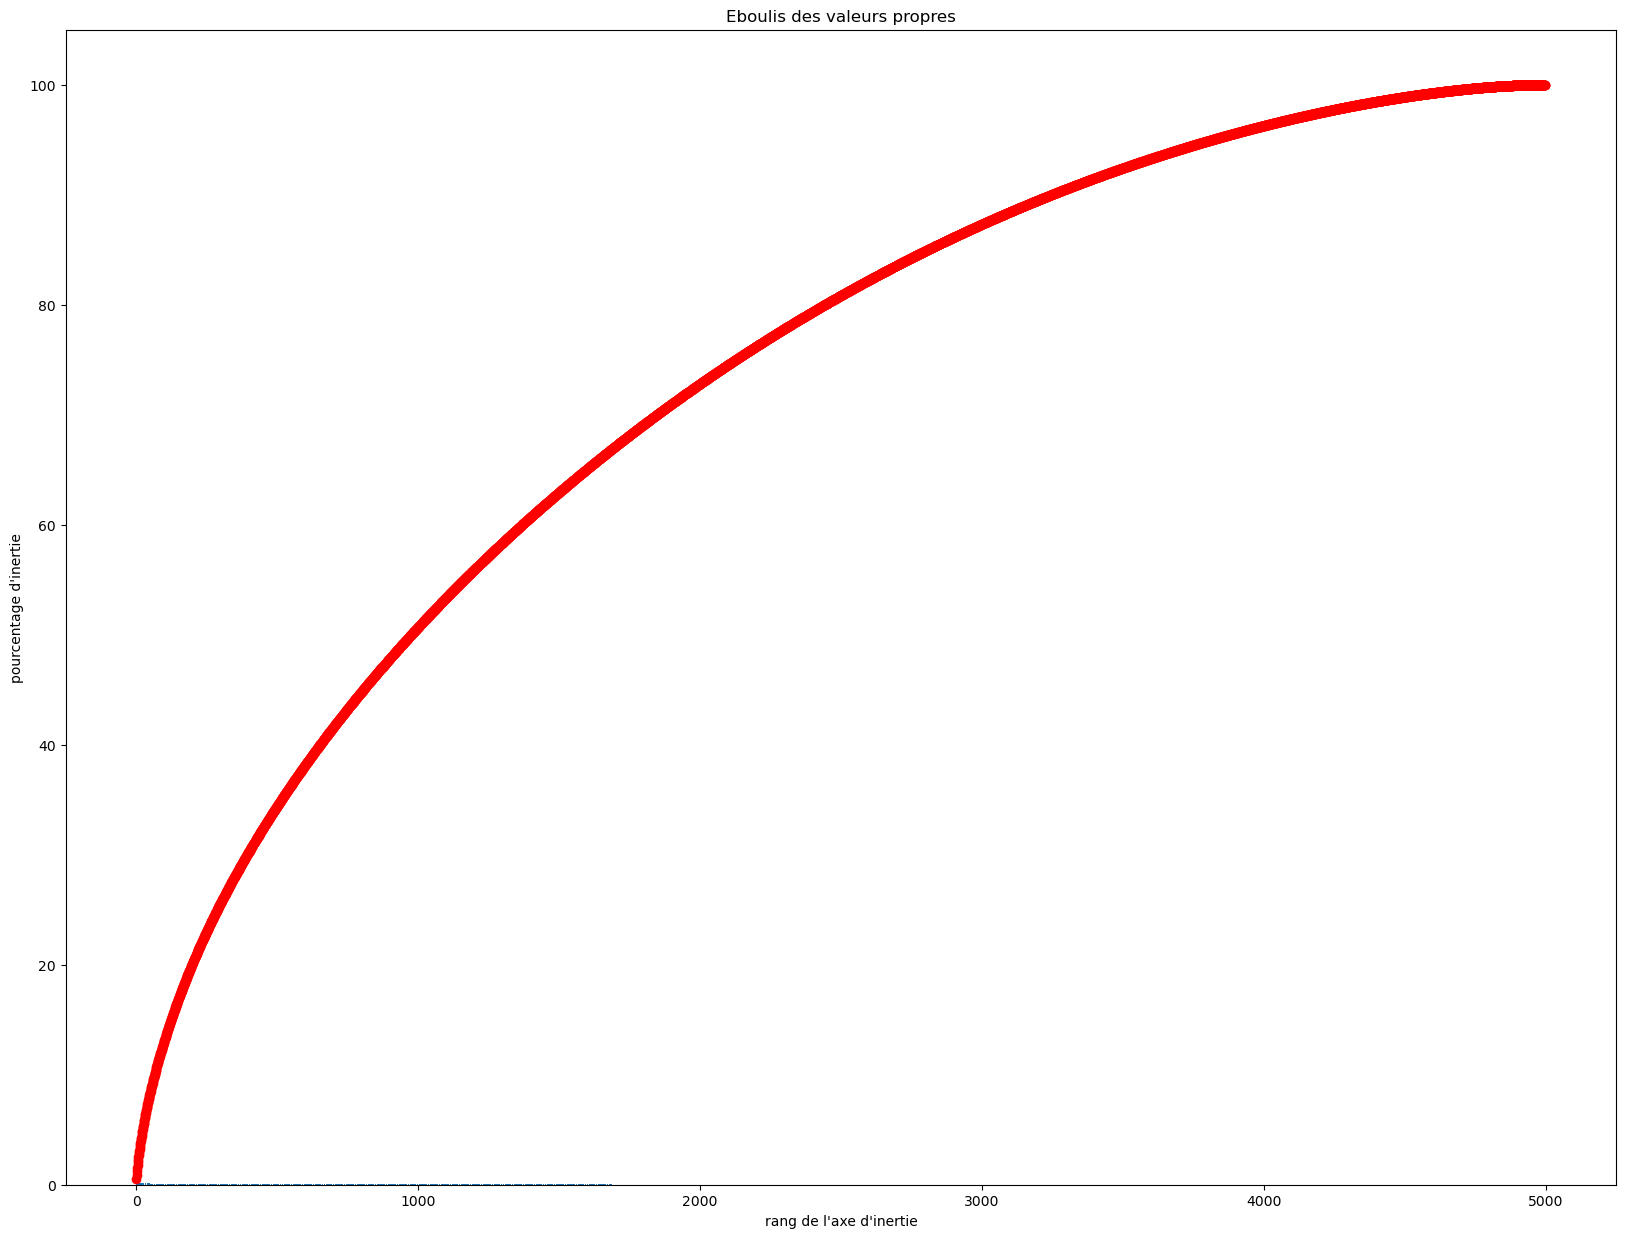

                 0
0     5.278541e-01
1     3.704710e-01
2     3.322877e-01
3     3.024204e-01
4     2.703831e-01
...            ...
4994  1.899140e-05
4995  1.280782e-05
4996  6.073861e-06
4997  3.941107e-06
4998  1.041613e-31

[4999 rows x 1 columns]


In [19]:
def display_scree_plot(pca):
    """
    Fonction qui affiche le graphique ébouli 
    """
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)
    print(pd.DataFrame(scree))
    
fig, ax = plt.subplots(figsize=(20, 15))    
display_scree_plot(pca)

Le nombre optimal de colonnes est de 2500. Nous avons développé deux fonctions qui permettent de transformer le jeu de données à l'aide de deux vectoriseurs différents.

In [20]:
def func_vectorizer (nb_colonnes) : 
    data_vc = []
    
    for items in ["Title T2N","Body T2N","Title + Body T2N" ]:

        appel = transform_vector(data, items, CountVectorizer, nb_colonnes)
        data_vc.append(appel["Vector Tranformed"])
    return data_vc

nb_colonnes = 2500
data_vc = func_vectorizer (nb_colonnes)

In [21]:
def func_tf_idf (nb_colonnes) : 
    
    data_tf = []
    for items in ["Title T2N","Body T2N","Title + Body T2N"] :

        appel = transform_vector(data, items, TfidfVectorizer, nb_colonnes)
        data_tf.append(appel["Vector Tranformed"])
        model = appel["Vectorizer" ]
        
    return data_tf, model

data_tf, model = func_tf_idf (nb_colonnes)

In [22]:
model_name = "Model_Tf_Id.pkl"

# entraînement du modèle ici...

# enregistrer le modèle à l'aide de pickle
with open(model_name, 'wb') as file:
    pickle.dump(model, file)

## MLB

Nous utilisons un MultiLabelBinarizer pour transformer la colonne "Tag" en une matrice numérique.

In [23]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MultiLabelBinarizer

In [24]:
def func_mlb (nb_tags):
    
    tags = data["tags"].tolist()
    mlb = MultiLabelBinarizer(classes = tags_filtered[:nb_tags])

    # Transformer la colonne 'tags'
    mlb.fit(tags)
    Tags_Target =  mlb.transform(tags)

    # Créer une nouvelle dataframe avec les colonnes binaires
    new_df =  pd.DataFrame(Tags_Target, columns=mlb.classes_)
    
    dico = {"Tags_Target" : Tags_Target, "DataFrame" : new_df, "tags" : tags, "mlb" : mlb }
    
    return dico
    
dico_mlb = func_mlb (50)
Tags_Target = dico_mlb ["Tags_Target"]
Df_target = dico_mlb ["DataFrame"]
tags = dico_mlb ["tags"]
mlb = dico_mlb ["mlb"]

On sauvegarde le modèle MLB pour le réutiliser.

In [25]:
model_name = "MLB.pkl"
# enregistrer le modèle à l'aide de pickle
with open(model_name, 'wb') as file:
    pickle.dump(mlb, file)

In [26]:
    
dico_mlb = func_mlb (200)
Tags_Target = dico_mlb ["Tags_Target"]
Df_target = dico_mlb ["DataFrame"]
tags = dico_mlb ["tags"]
mlb = dico_mlb ["mlb"]

In [27]:
Df_target

,python,android,java,javascript,net,spring,js,io,core,node,...,notebook,promise,mobile,woocommerce,intellij,axios,ios11,form,logging,browser
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42106,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Voici les classes dans notre colonne Tag.

In [28]:
mlb.classes_

array(['python', 'android', 'java', 'javascript', 'net', 'spring', 'js',
       'io', 'core', 'node', 'asp', 'angular', 'reactjs', 'swift',
       'react', 'amazon', 'typescript', 'google', 'studio', 'docker',
       'html', 'firebase', 'web', 'learning', 'testing', 'php', 'boot',
       'flutter', 'panda', 'laravel', 'visual', 'cs', 'azure', 'vue',
       'django', 'kotlin', 'api', 'json', 'sql', 'tensorflow', 'data',
       'linux', 'services', 'xcode', 'webpack', 'apache', 'machine',
       'native', 'selenium', 'kera', 'numpy', 'macos', 'image', 'gradle',
       'unit', 'performance', 'aws', '11', 'npm', 'array', 'server',
       'redux', 'mvc', 'dataframe', 'jquery', 'language', 'window',
       'code', 'lambda', 'framework', 'dart', 'chrome', 'spark', 'git',
       'http', 'deep', 'lawyer', 'mysql', 'network', 'memory', 'type',
       'maven', 'material', 'database', 'neural', 'security',
       'postgresql', 'jestjs', 'bootstrap', 'template', 'string',
       'ubuntu', 'express'

In [29]:
print(f"Les dimensions de la target sont de {Tags_Target.shape}.")

Les dimensions de la target sont de (42110, 200).


## Vectorizer


Nous avons créé des dictionnaires contenant les données transformées en vecteurs à l'aide des vectorizers que nous avons mis en place précédemment. Ces dictionnaires nous permettent d'accéder aux données transformées sous une forme facilement manipulable pour la suite de l'analyse.

In [30]:
data_vectorizer = {
                    "Title Vectorizer" : data_vc[0],
                    "Body Vectorizer"  : data_vc[1],
                    "Body + Title Vectorizer"  : data_vc[2]
    
                  }

In [31]:
data_tf_id = {
                    "Title TF" : data_tf[0],
                    "Body TF"  : data_tf[1],
                "Body + Title TF"  : data_tf[2]
                  }

In [32]:
data_tf_id ["Body + Title TF"]

,able,absolute,abstract,abstractbeanfactory,accept,accepted,access,accessible,accessing,accesstoken,...,xxxx,yaml,yarn,year,yield,youtube,zero,zone,zoom,zygoteinit
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.024857,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42105,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42106,0.028013,0.0,0.0,0.0,0.0,0.0,0.177628,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42107,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42108,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Milestone 3 : Proposition de mots clés – Approche non supervisée

À cette étape, nous souhaitons utiliser un modèle d'approche non supervisée pour améliorer notre modèle.

In [31]:
sns.set()
import warnings
from gensim.models.nmf import Nmf
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
warnings.filterwarnings("ignore")
from gensim.models import TfidfModel
from gensim.corpora.dictionary import Dictionary

Nous avons mis en place des fonctions pour afficher les tags dans notre modèle supervisé.

In [32]:
n_features = 2000
n_components = 40
n_top_words = 5

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(4, 10, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    dico = []
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
        dico.append({"top Features" : top_features, "Weights" : weights })
        
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


In [33]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("")
     

In [34]:
X = data_tf_id["Title TF"]

On fait un premier test la fonction NMF.

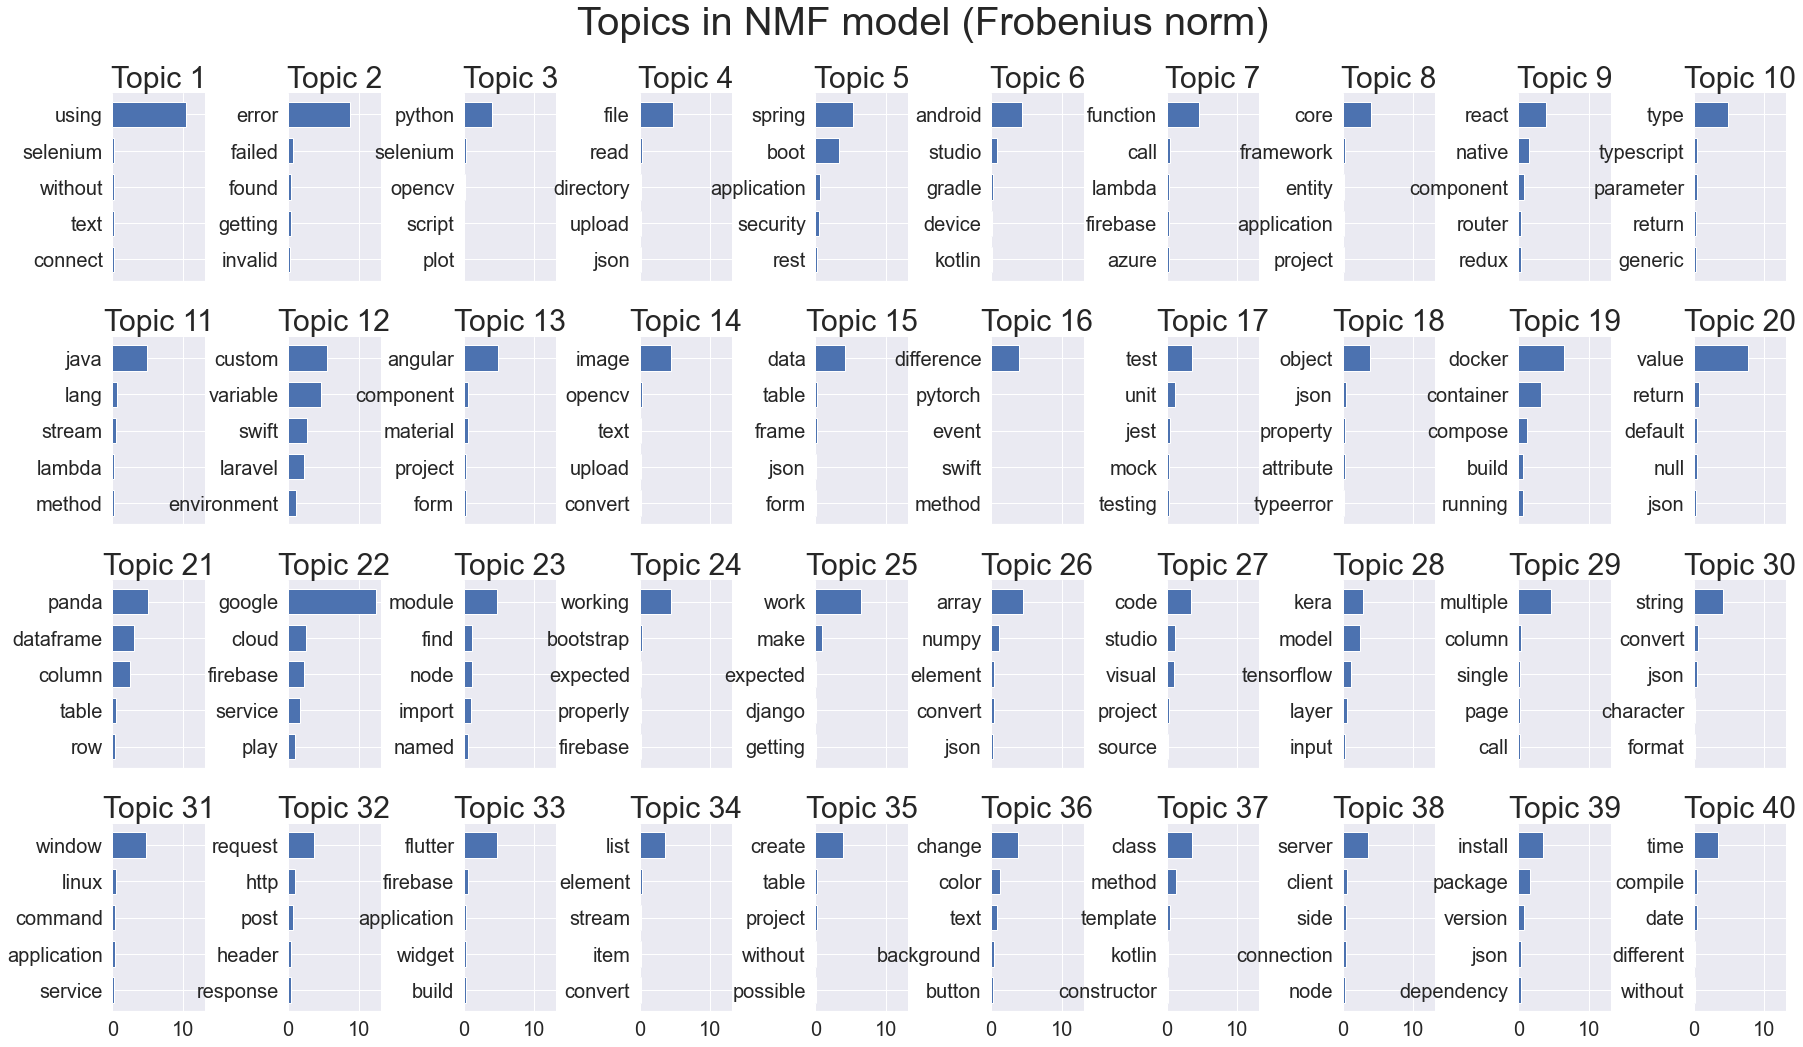

In [35]:
nmf = NMF(n_components=n_components, random_state=1,
           l1_ratio=.5).fit(X)

plot_top_words(nmf, X.columns, n_top_words,
               'Topics in NMF model (Frobenius norm)')

On fait un premier test la fonction LDA.

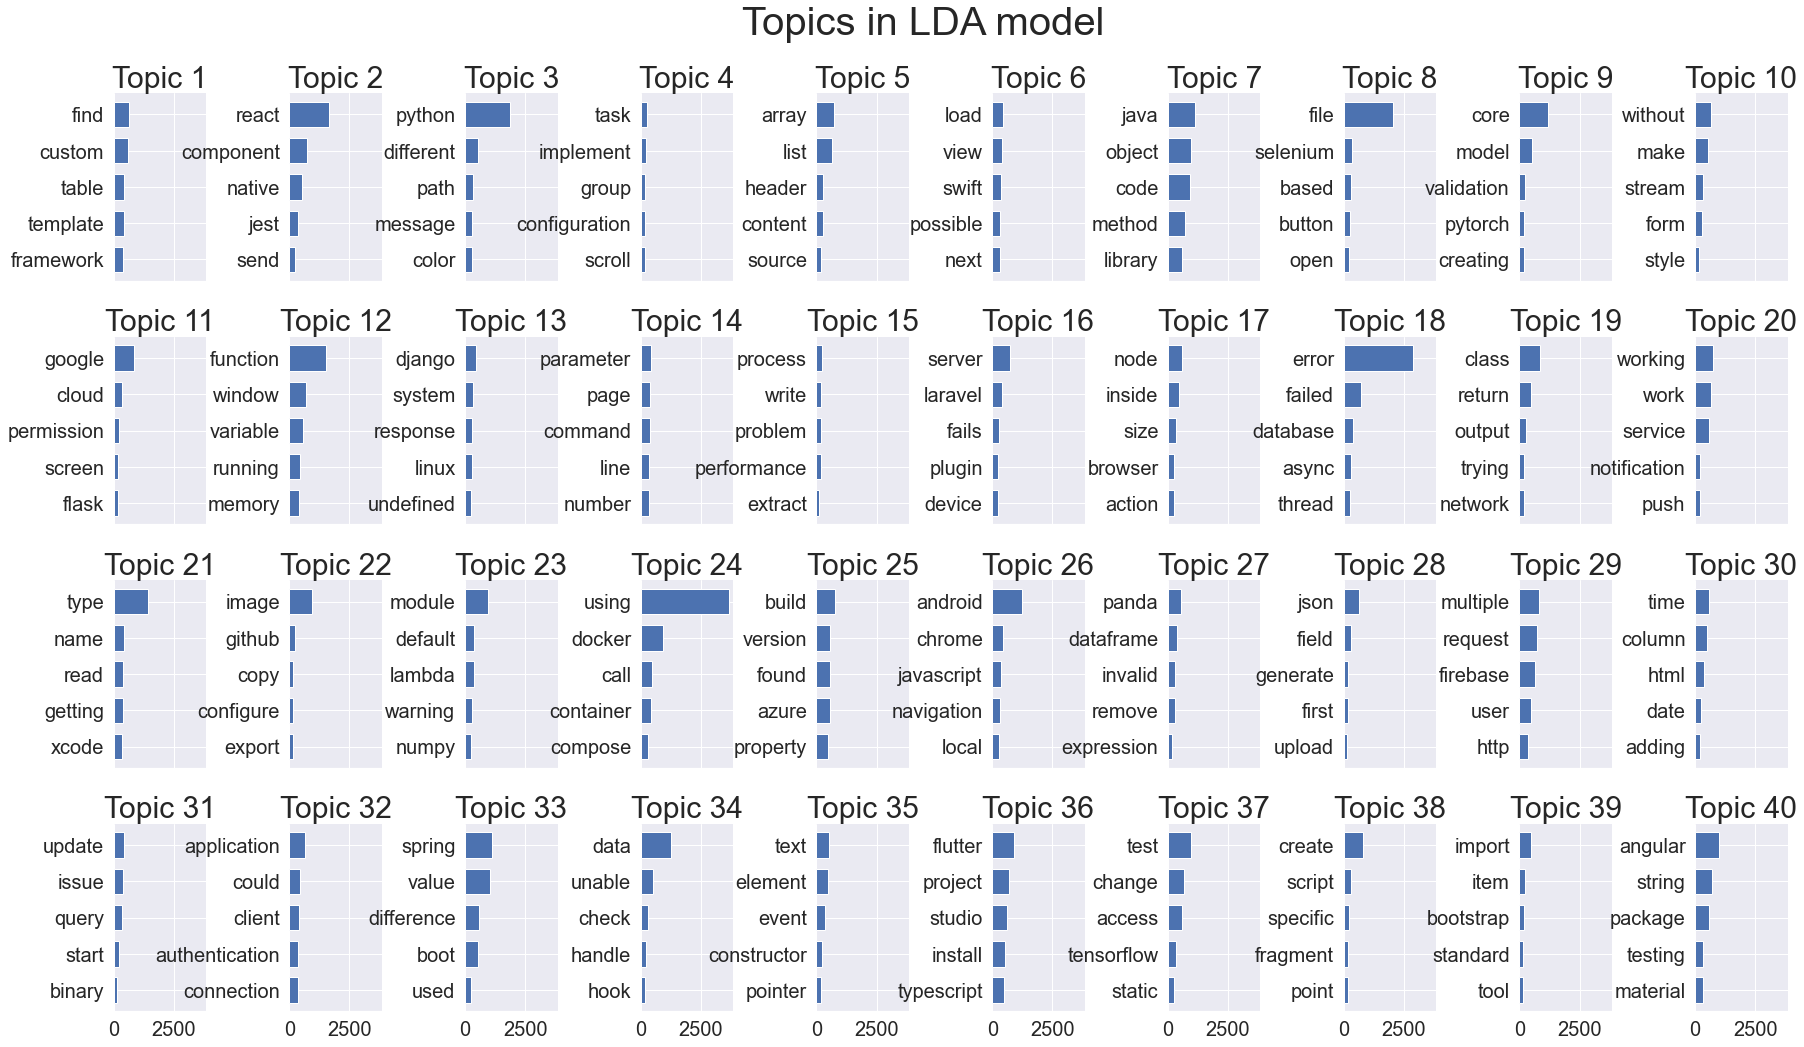

In [36]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
X = data_vectorizer["Title Vectorizer"]
lda.fit(X)
plot_top_words(lda,  X.columns, n_top_words, 'Topics in LDA model')

In [38]:
best_lda_model_stopwords = lda
no_top_words = 5
display_topics(best_lda_model_stopwords,tfidf_feature_names_, no_top_words)

Topic 0:
blocked atomic decimal declare branch

Topic 1:
controller applying comment certificate csproj

Topic 2:
context automation conda cocoapods append

Topic 3:
declaration camera bypass appsync creator

Topic 4:
adapter class cached arkit dark

Topic 5:
classification design debian connecting compare

Topic 6:
centos compiling appear codable chromedriver

Topic 7:
blob crypto allocation amount complete

Topic 8:
assert collector depth continuous asynchronous

Topic 9:
detection close date border day

Topic 10:
builder apollo conditionally creating boolean

Topic 11:
break detected description crashing clustering

Topic 12:
avoid debugging coroutines clang deleted

Topic 13:
compute composition application circular compile

Topic 14:
constexpr devtools constant conditional bind

Topic 15:
csrf checkout bit configuring automatic

Topic 16:
comparing cart cython amazon absolute

Topic 17:
basic binding attempting adding decorator

Topic 18:
anything correlation compose defined commu

## Meilleur TOPIC

Nous souhaitons déterminer le score de cohérence des différents sujets (topics).

In [39]:
def get_Cv(model, df_columnm):
    
    topics = model.components_

    n_top_words = 20
    texts = [[word for word in doc.split()] for doc in df_columnm]

  # create the dictionary
    dictionary = corpora.Dictionary(texts)
  # Create a gensim dictionary from the word count matrix

  # Create a gensim corpus from the word count matrix
    corpus = [dictionary.doc2bow(text) for text in texts]

    feature_names = [dictionary[i] for i in range(len(dictionary))]

  # Get the top words for each topic from the components_ attribute
    top_words = []
    for topic in topics:
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

    coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    
    return coherence

Dans cette étape, nous cherchons à déterminer le nombre optimal de topics pour notre modèle LDA et NMF. Pour ce faire, nous calculons le score de cohérence pour différents nombres de topics, allant de 8 à 44. Le score de cohérence nous permet de mesurer la qualité des topics générés par notre modèle, et ainsi déterminer le nombre optimal de topics à utiliser.

In [40]:
from gensim.models import TfidfModel
import gensim


Text = data["Title T2N"].astype(str)
texts = [d.split() for d in Text]
dictionary = Dictionary(texts)
id2word = dictionary

dictionary.filter_extremes(no_below=4, no_above=0.6, keep_n=5000)

corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
tfidf_corpus = [tfidf[text] for text in corpus]

corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
tfidf_corpus = [tfidf[text] for text in corpus]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(8, 44 , 4))

from gensim.corpora.dictionary import Dictionary

coherence_scores_NMF = []
coherence_scores_LDA = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores_NMF.append(round(cm.get_coherence(), 5))
    
    ## Coherence score LDA
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=tfidf_corpus,
                                  id2word=id2word,
                                  num_topics= num ,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')

    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores_LDA.append(round(    coherence_lda, 5))



# Nombre de TOPIC max par méthodes.


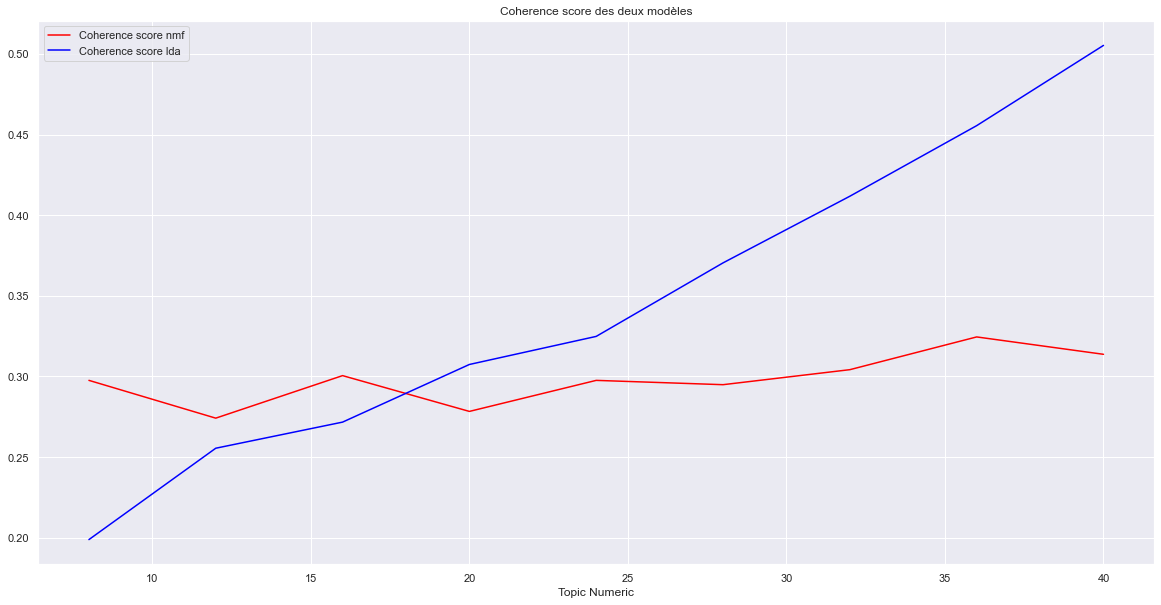

In [41]:
scores = list(zip(topic_nums, coherence_scores_NMF))
scores2 = list(zip(topic_nums, coherence_scores_LDA))


best_num_topics = sorted(scores2, key=lambda elem: elem[1], reverse=True)[0][0]
best_num_topics_2 = sorted(scores, key=lambda elem: elem[1], reverse=True)[0][0]
#plt.figure(figsize=(12,6))
df=pd.DataFrame({'Topic Numeric': topic_nums,'Coherence score nmf': coherence_scores_NMF, "Coherence score lda" : coherence_scores_LDA})
df = df.set_index("Topic Numeric")


df["Coherence score nmf"].plot(figsize = (20,10),color = 'red')
df["Coherence score lda"].plot(figsize = (20,10),color = 'blue')
plt.title("Coherence score des deux modèles")

plt.legend()
plt.show()

On détermine le nombre optimal de topic.

In [42]:
print('NMF model Best topic:' + str(best_num_topics))
print("LDA model Best topic:" + str(best_num_topics_2 ))

NMF model Best topic:40
LDA model Best topic:36


In [43]:
X = data_vectorizer["Title Vectorizer"]

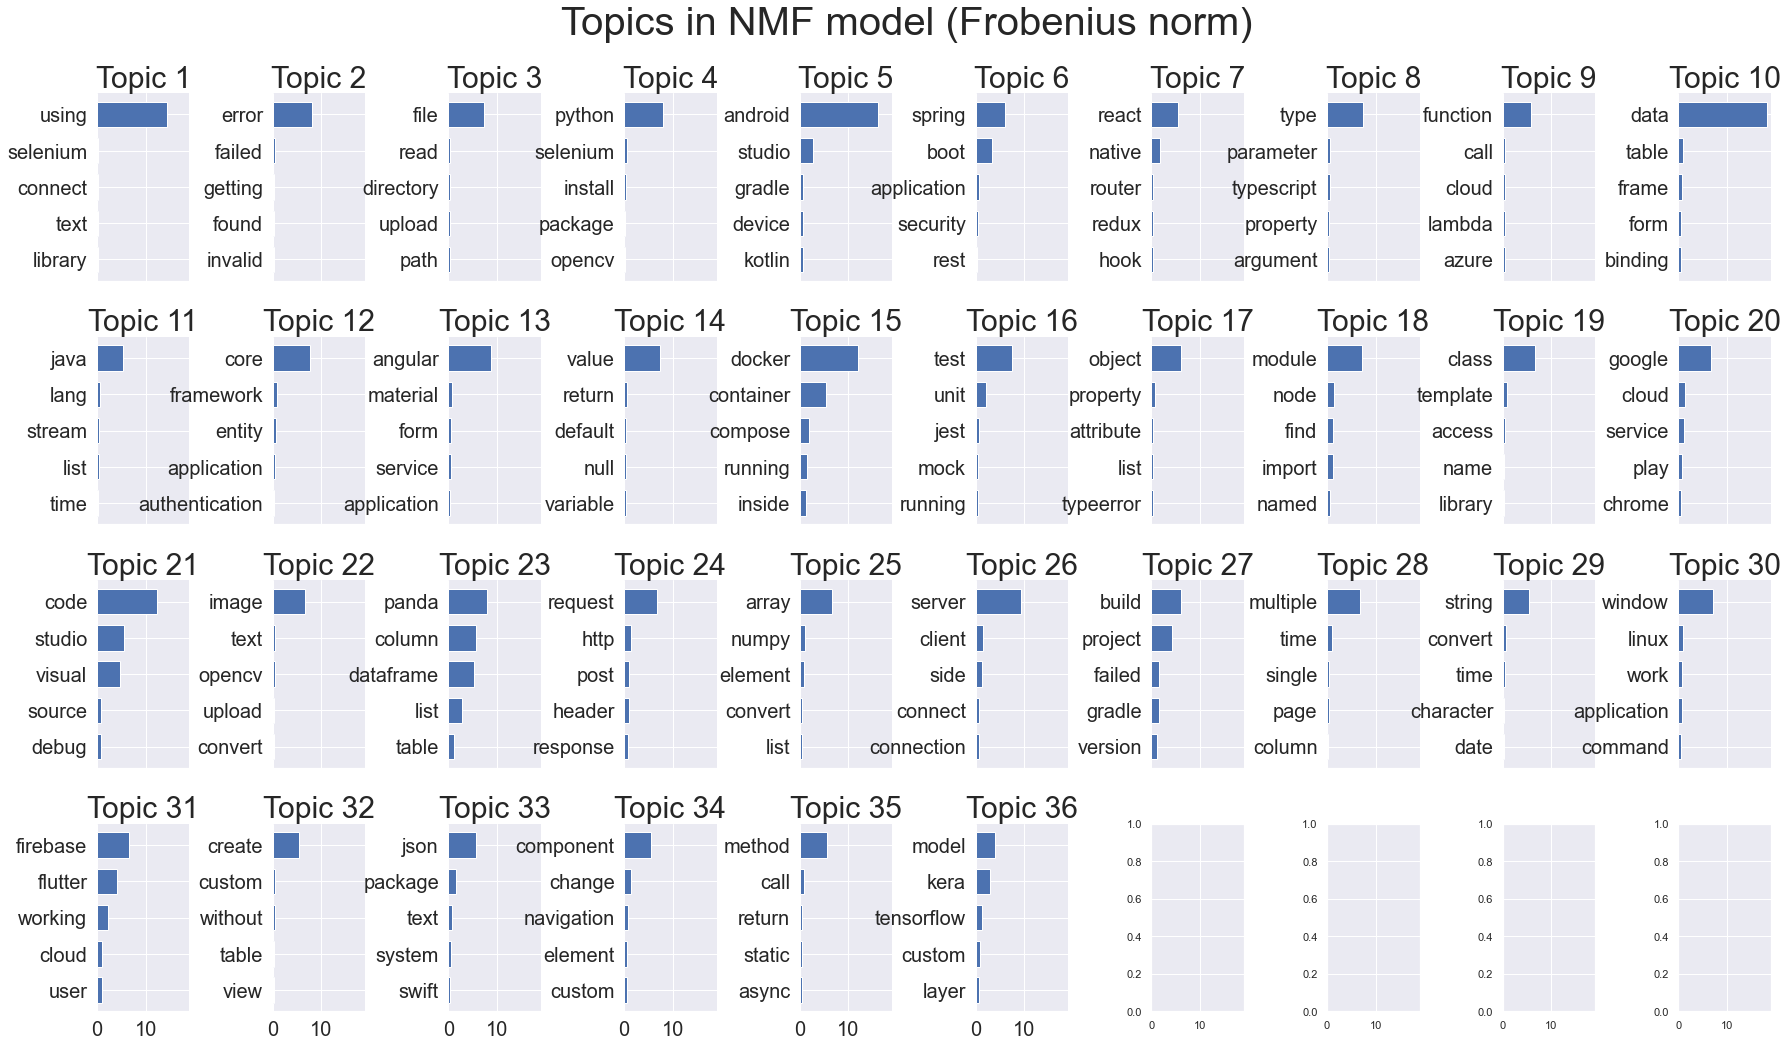

In [44]:
n_features = 2000
n_components = 36                                                           
n_top_words = 5

nmf = NMF(n_components=n_components, random_state=1,
           l1_ratio=.5).fit(X)


plot_top_words(nmf, X.columns, n_top_words,
               'Topics in NMF model (Frobenius norm)')

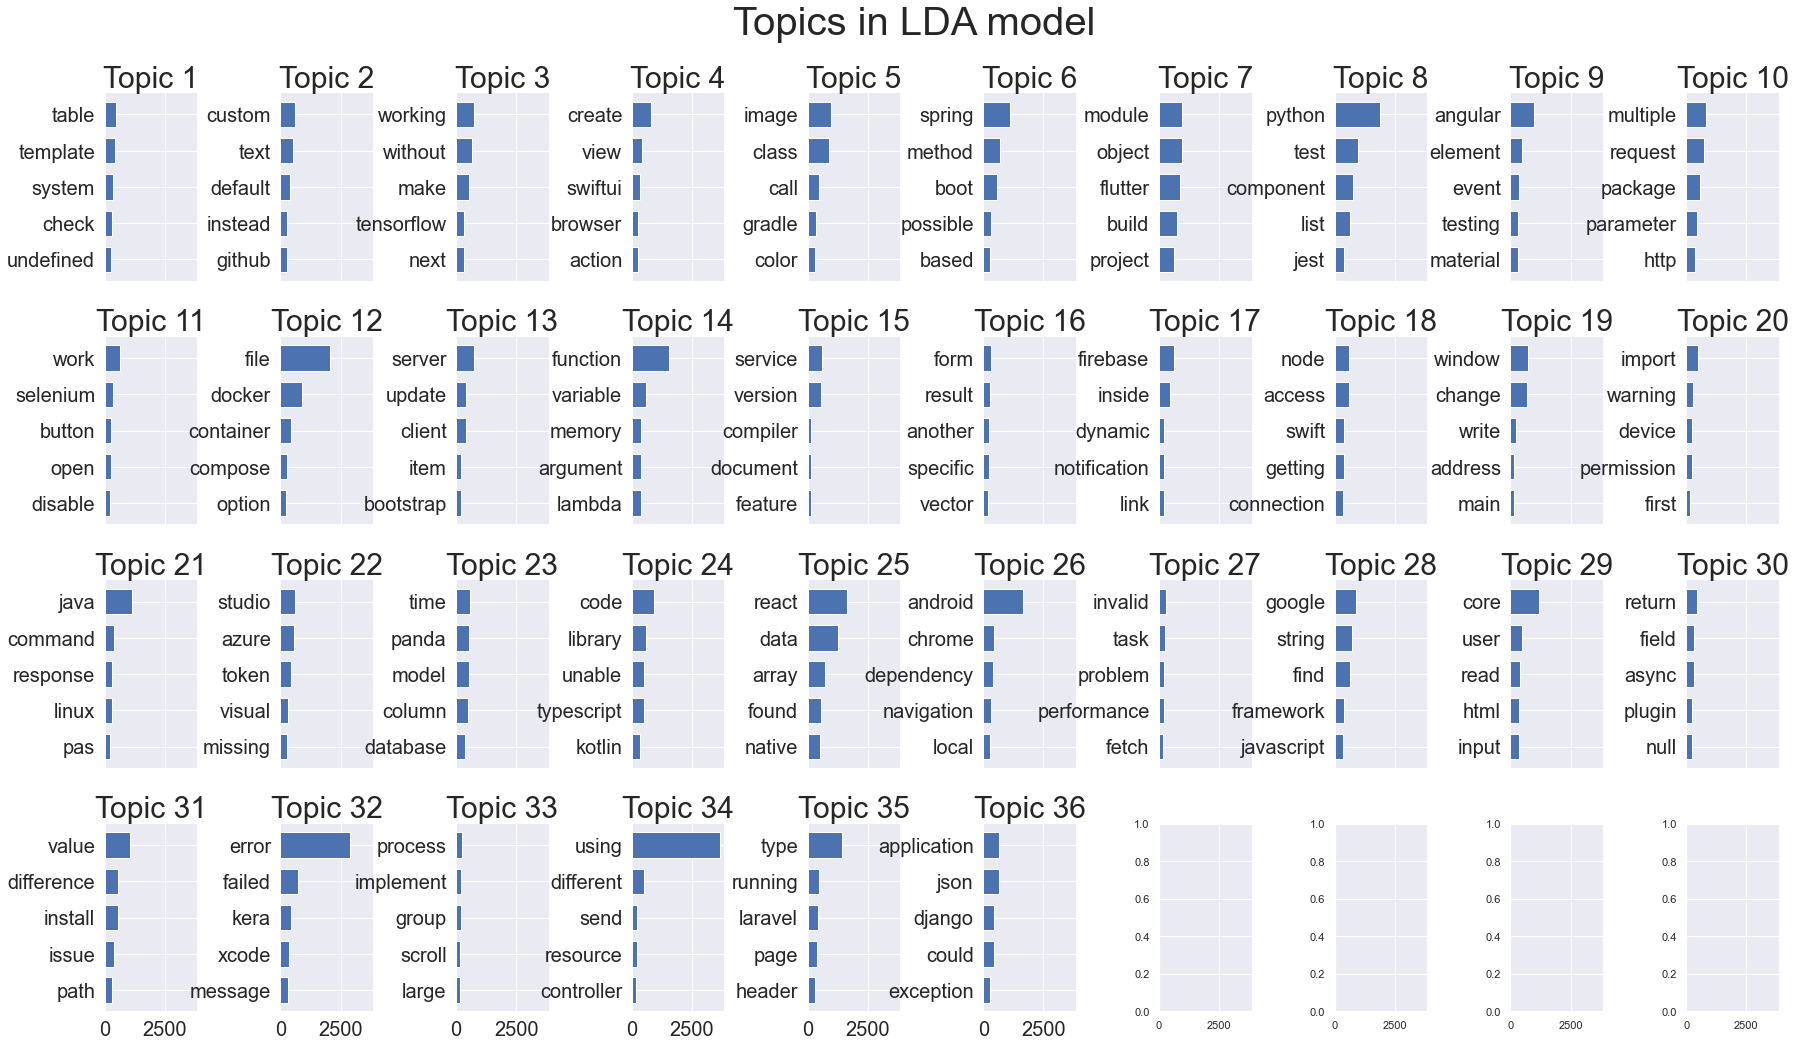

In [45]:
lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)

lda.fit(X)
plot_top_words(lda,  X.columns, n_top_words, 'Topics in LDA model')

Pour la suite de cette partie, nous avons choisi le modèle LDA. Nous avons créé une fonction qui affecte des tags sur le modèle sous forme de dataframe, avec le sujet dominant (TOPIC), son pourcentage et les mots clés associés.

In [46]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [47]:
lda_best = LdaModel(tfidf_corpus, num_topics=36, id2word=dictionary)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_best, corpus=tfidf_corpus, texts=texts)

original_cleaned_keywords = data['Tags']

In [48]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0,7.0,0.1935,"docker, memory, gradle, background, container,...","[client, side, still, using, interpreted, lang...","['javascript', 'optimization', 'web', 'interpr..."
1,1,23.0,0.2498,"text, load, remove, client, format, fails, han...","[coroutine, threading, context, coroutine, sch...","['c++', 'multithreading', 'async-await', 'coro..."
2,2,11.0,0.3670,"function, firebase, cloud, instead, large, ind...","[calculate, percentile, long, array]","['java', 'math', 'statistic', 'apache-commons'..."
3,3,11.0,0.4487,"function, firebase, cloud, instead, large, ind...","[microsoft, extension, logging, console, appli...","['dependency-injection', 'asp.net-core', 'auto..."
4,4,8.0,0.3461,"default, mysql, swagger, compare, stored, long...","[jquery, datatable, placing, custom, loading, ...","['javascript', 'jquery', 'ajax', 'datatables',..."
5,5,5.0,0.6359,"property, create, undefined, kotlin, read, obj...","[enum, value, type]","['c++', 'c++11', 'enums', 'metaprogramming']"
6,6,7.0,0.4110,"docker, memory, gradle, background, container,...","[yoast, wordpress, plugin, laravel]","['javascript', 'php', 'laravel', 'browserify',..."
7,7,12.0,0.3456,"django, could, action, available, resolve, fin...","[gulp, secondary, asset]","['javascript', 'cs', 'gulp', 'bower', 'asset']"
8,8,5.0,0.1989,"property, create, undefined, kotlin, read, obj...","[panda, read, memory, consumption]","['python-3.x', 'panda', 'memory', 'memory-mana..."
9,9,24.0,0.2156,"link, required, public, generate, user, algori...","[handling, mongoose, populated, field, graphql]","['node.js', 'mongodb', 'mongoose', 'graphql', ..."


On regroupe le dataframe par topic dominant.

In [49]:
sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7114,"flutter, azure, project, running, best, task, ...","[internal, framework, data, provider, error, a..."
1,1.0,0.6891,"library, another, validation, write, able, thr...","[running, code, elixir, erlang, port, nifs]"
2,2.0,0.7157,"template, list, variable, nested, scroll, inst...","[convert, string, date, time, panda, datetime]"
3,3.0,0.7140,"working, size, screen, test, dependency, butto...","[angular, handle, async, image, blob, request]"
4,4.0,0.6734,"react, package, used, native, emulator, lambda...","[module, preinstalled, lambda, execution, envi..."


In [50]:
%%time 
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
df_dominant_topics_prop["Perc_Documents"] = df_dominant_topics_prop["Perc_Documents"]*100
# Show
df_dominant_topics_prop

Wall time: 6 ms


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"flutter, azure, project, running, best, task, ...",1976,4.69
1.0,1.0,"library, another, validation, write, able, thr...",979,2.32
2.0,2.0,"template, list, variable, nested, scroll, inst...",1467,3.48
3.0,3.0,"working, size, screen, test, dependency, butto...",1301,3.09
4.0,4.0,"react, package, used, native, emulator, lambda...",1547,3.67
5.0,5.0,"property, create, undefined, kotlin, read, obj...",1358,3.22
6.0,6.0,"install, output, window, document, ubuntu, fra...",1050,2.49
7.0,7.0,"docker, memory, gradle, background, container,...",1159,2.75
8.0,8.0,"default, mysql, swagger, compare, stored, long...",940,2.23
9.0,9.0,"element, select, prevent, missing, many, time,...",1155,2.74


À cette étape, nous cherchons à évaluer la performance de notre modèle de prédiction de tags. Pour ce faire, nous allons comparer les tags prédits par notre modèle supervisé avec les tags générés par notre modèle non supervisé. Nous allons utiliser des scores pour mesurer la qualité de la prédiction des tags, tels que la précision, le rappel et le score F1. Ces scores nous permettront de déterminer si notre modèle de prédiction de tags est performant ou s'il nécessite des améliorations.

In [51]:
def affect_tags(model,tags_mlb):
  # Calculate Document/topic matrix with Gensim
  doc_topic = pd.DataFrame(model\
                             .get_document_topics(corpus,
                                                  minimum_probability=0))
  for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

  # Matricial multiplication with Document / Topics transpose
  topic_tag = np.matmul(doc_topic.T, tags_mlb)
  y_results = pd.DataFrame(data['Tags'])
  y_results["best_topic"] = doc_topic.idxmax(axis=1).values
  y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

  df_y_bin = pd.DataFrame(tags_mlb)
  df_dict = dict(list( df_y_bin.groupby(df_y_bin.index)))
  
  tags_num = []
  for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())
  y_results["y_true"] = tags_num

  # Select predicted tags in Topics / Tags matrix
  list_tag = []
  for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
  y_results["y_pred"] = list_tag
  return y_results

In [52]:
dico_mlb = func_mlb (10000)
Tags_Target = dico_mlb ["Tags_Target"]
Df_target = dico_mlb ["DataFrame"]
tags = dico_mlb ["tags"]
mlb = dico_mlb ["mlb"]
affect_tags(lda_best,Tags_Target)

,Tags,best_topic,nb_tags,y_true,y_pred
0,"['javascript', 'optimization', 'web', 'interpr...",7,82,"[3, 22, 145]","[19, 0, 2, 1, 3, 53, 25, 7, 203, 13, 12, 41, 1..."
1,"['c++', 'multithreading', 'async-await', 'coro...",23,70,[93],"[0, 3, 1, 2, 7, 12, 13, 20, 11, 31, 16, 25, 19..."
2,"['java', 'math', 'statistic', 'apache-commons'...",11,61,[2],"[0, 3, 21, 1, 2, 7, 12, 13, 16, 11, 28, 20, 27..."
3,"['dependency-injection', 'asp.net-core', 'auto...",11,62,[],"[0, 3, 21, 1, 2, 7, 12, 13, 16, 11, 28, 20, 27..."
4,"['javascript', 'jquery', 'ajax', 'datatables',...",8,65,"[3, 64, 205]","[2, 0, 3, 77, 1, 5, 7, 161, 11, 12, 13, 16, 25..."
...,...,...,...,...,...
42105,"['c++', 'boolean', 'rvalue', 'lvalue', 'value-...",13,58,[],"[3, 0, 2, 1, 12, 7, 37, 13, 61, 16, 5, 11, 90,..."
42106,"['python', 'email', 'oauth-2.0', 'office365', ...",1,53,[0],"[0, 3, 2, 1, 7, 93, 12, 13, 11, 16, 20, 28, 31..."
42107,"['c++', 'pointer', 'struct', 'undefined-behavi...",29,69,[274],"[3, 0, 44, 2, 12, 31, 1, 20, 16, 7, 13, 11, 39..."
42108,"['.net', 'jenkins', 'deployment', 'cicd']",34,41,"[158, 226]","[1, 2, 0, 3, 12, 7, 35, 16, 53, 158, 13, 11, 2..."


In [53]:
from numpy.lib.function_base import average
from sklearn import metrics, cluster, preprocessing


def metrics_score(model,y_true, y_pred,tags_mlb):
  model_y_pred = np.zeros(tags_mlb.shape)
  n = 0
  for row in y_pred:
    for i in range(len(row)):
      model_y_pred[n,row[i]] = 1
    n+=1
  model_y_true = np.zeros(tags_mlb.shape)
  m = 0
  for row in y_true:
    for i in range(len(row)):
      model_y_true[m,row[i]] = 1
    m+=1
  y_true=model_y_true
  y_pred=model_y_pred
    
  
  scores = []
  scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='micro'))
    
  scores.append(metrics.accuracy_score(y_pred, 
                                   y_true))
  scores.append(metrics.recall_score(y_pred, 
                                   y_true, 
                                   average='micro'))
    
  scores.append(metrics.precision_score(y_pred, 
                                   y_true, 
                                   average='micro'))

  scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='micro'))
    
  Dico = { "Jaccard_score" : [scores[0]],    
            "accurracy" : [scores[1]],
            "recall" : [scores[2]],
            "precision" : [scores[3]],
            "f1" : [scores[4]],
            "fit Time" : [100]
                              }


  return Dico

In [54]:
df_metrics_compare = metrics_score('LDA',affect_tags(lda_best,Tags_Target).y_true,affect_tags(lda_best,Tags_Target).y_pred,Tags_Target)
df_metrics_compare

{'Jaccard_score': [0.025437967721933512],
 'accurracy': [0.0],
 'recall': [0.025605886524454752],
 'precision': [0.7950411379857256],
 'f1': [0.04961385968269802],
 'fit Time': [100]}

C'est une étape importante dans l'évaluation de notre modèle de prédiction de tags pour les questions Stack Overflow. Nous allons comparer les tags prédits par notre modèle supervisé avec les tags générés par notre modèle non supervisé.

Nous allons utiliser des scores tels que la précision, le rappel et le score F1 pour évaluer la qualité de la prédiction des tags et déterminer si notre modèle de prédiction est performant ou non. Les résultats obtenus pour cette méthode montrent des scores très bas, ce qui indique que cette approche n'est probablement pas suffisante pour notre modèle.


# Milestone 4 : Proposition de mots clés – Approche supervisée classique

Dans cette partie, nous souhaitons mettre en pratique une approche supervisée classique avec en entrée les données "Title" et "Body" avec en cible les données dans la colonne "Tags". Nous allons utiliser le modèle de OneVsRestClassifier en utilisant plusieurs modèles tels que SGD, PassiveAgressive ou encore Logistic Regression.

On crée une première fonction qui permet de diviser notre jeu de données en plusieurs parties.

In [33]:
def func_Train_Test_Split (T, Feat):

    """
    Fonction de séparation train/test set
    
    df : Dataftame en entrée
    T : Liste composée des variables cibles
    Feat : Liste composée des features

    """
    X = Feat
    Y = T
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3 , random_state = 100, shuffle=True)
    
    return x_train, x_test, y_train, y_test

La fonction que vous décrivez prend en entrée un modèle, les données (X) et les labels (y), et renvoie les scores de performance du modèle (précision, rappel, score F1, jaccard score) ainsi que le modèle entrainé.

In [34]:
def Modele_ML (model,Target, Feats, Nom, Feat_treat) :

    """
    Fonction qui donne les métrics ainsi que le modèle entrainé
    https://towardsdatascience.com/8-metrics-to-measure-classification-performance-984d9d7fd7aa
    """
    
    x_train, x_test, y_train, y_test = func_Train_Test_Split (Target, Feats)
    Model = model
    time_start = time.perf_counter()
    Model.fit(x_train ,y_train)
    time_end = time.perf_counter()
    y_Predict = Model.predict(x_test)

    J_Score = jaccard_score(y_test, y_Predict, average = "micro")
    accurracy = accuracy_score(y_test, y_Predict)
    recall = recall_score(y_test, y_Predict, average = "micro")
    precision = precision_score(y_test, y_Predict, average = "micro")
    f1 =  f1_score(y_test, y_Predict, average = "micro")

    print(f'Entrainement du modèle : {Nom}\n')
    print(f' jaccard score = {J_Score} ')

    model_resume = {
                    'Model':[Nom],
                    'Features Traitement' : [Feat_treat],
                    'Jaccard' : [J_Score],
                    'accuracy' : [accurracy],
                    'recall': [recall],
                    'precision' : [precision],
                    'f1':[f1],
                    'fit time' : [time_end - time_start]

                   }
    

    Df_model = pd.DataFrame(model_resume)
   
    return  model_resume, Model, Df_model

In [35]:
dico_mlb = func_mlb (50)
Tags_Target = dico_mlb ["Tags_Target"]
Df_target = dico_mlb ["DataFrame"]
tags = dico_mlb ["tags"]
mlb = dico_mlb ["mlb"]

## OneVsRestClassifier 

Pour cette classification on utilise le OneVsRestClassifier. Le OneVsRestClassifier est un modèle de classification multi-classes. Il permet de transformer un modèle de classification binaire en un modèle de classification multi-classes en appliquant la méthode "one-vs-rest". Cette méthode consiste à entraîner un classificateur pour chaque classe en la considérant comme positive et toutes les autres classes comme négatives. Ensuite, pour chaque exemple à prédire, on choisit la classe pour laquelle le classificateur prédit la probabilité la plus élevée. 

Pour évaluer la performance de notre modèle de prédiction de tags, nous allons tester plusieurs méthodes de classification supervisée : la régression logistique, le SGD Classifier et le Passive Aggressive. 

Nous allons utiliser les deux approches de vectorisation de texte que nous avons précédemment développées (CountVectorizer et TfidfVectorizer) pour chacune de ces méthodes de classification. Nous utiliserons ensuite les scores de précision, de rappel, jaccard score et de F1 pour évaluer la performance de chaque modèle.

## Logitic Regression

In [36]:
X = data_tf_id["Body + Title TF"]

In [37]:
X 

,able,absolute,abstract,abstractbeanfactory,accept,accepted,access,accessible,accessing,accesstoken,...,xxxx,yaml,yarn,year,yield,youtube,zero,zone,zoom,zygoteinit
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.024857,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42105,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42106,0.028013,0.0,0.0,0.0,0.0,0.0,0.177628,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42107,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42108,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
Model_LR= OneVsRestClassifier(LogisticRegression(random_state = 1))
Model_LR_resume, Model_LR_Trained, DF_LR = Modele_ML(Model_LR,Tags_Target, X , "Model Logistic Regression", "TF IDF")

Entrainement du modèle : Model Logistic Regression

 jaccard score = 0.4509501797637391 


In [39]:
Data_Synthèse = pd.DataFrame(data = Model_LR_resume)
Data_Synthèse 

,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.45095,0.509459,0.5,0.821328,0.621593,79.525462


In [40]:
X = data_vectorizer["Body + Title Vectorizer" ]
Model_LR_resume_V, Model_LR_Trained_V, DF_LR_V = Modele_ML(Model_LR,Tags_Target, X , "Model Logistic Regression",  "Vectorizer")

Entrainement du modèle : Model Logistic Regression

 jaccard score = 0.433631699596114 


In [41]:
Data_add = pd.DataFrame (data = Model_LR_resume_V)
Data_Synthèse = Data_Synthèse.append(Data_add)
Data_Synthèse

,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,79.525462
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,192.083177


## SGD Classifier

In [42]:
from sklearn.linear_model import SGDClassifier

In [43]:
SGD_Model = OneVsRestClassifier(SGDClassifier(random_state = 1))

In [44]:
X = data_tf_id["Body + Title TF"]


In [47]:
Model_SGD_resume, Model_SGD_Trained, DF_SGD = Modele_ML(SGD_Model,Tags_Target, X , "Model SGD", "TF IDF")

Entrainement du modèle : Model SGD

 jaccard score = 0.48806008473488255 


In [48]:
Data_add = pd.DataFrame (data = Model_SGD_resume)
Data_Synthèse = Data_Synthèse.append(Data_add)
Data_Synthèse

,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,79.525462
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,192.083177
0,Model SGD,TF IDF,0.488060,0.533682,0.541216,0.832476,0.655968,33.422571


In [49]:
import pickle

# nom du modèle à enregistrer
model_name = "Modele SGD Tf IDF.pkl"

# entraînement du modèle ici...

# enregistrer le modèle à l'aide de pickle
with open(model_name, 'wb') as file:
    pickle.dump(Model_SGD_Trained, file)

In [50]:
X = data_vectorizer["Body + Title Vectorizer" ]
Model_SGD_resume_V, Model_SGD_Trained_V, DF_SGD_V = Modele_ML(SGD_Model,Tags_Target, X , "Model SGD", "Vectorizer")

Entrainement du modèle : Model SGD

 jaccard score = 0.4202330771138111 


In [51]:
Data_add = pd.DataFrame (data = Model_SGD_resume_V)
Data_Synthèse = Data_Synthèse.append(Data_add)
Data_Synthèse

,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,79.525462
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,192.083177
0,Model SGD,TF IDF,0.488060,0.533682,0.541216,0.832476,0.655968,33.422571
0,Model SGD,Vectorizer,0.420233,0.414153,0.603218,0.580769,0.591780,151.913451


#  PassiveAggressiveClassifier

In [52]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [53]:
PAC_Model = OneVsRestClassifier(PassiveAggressiveClassifier(random_state = 1))
X = data_tf_id["Body + Title TF"]
Model_PAC_resume, Model_PAC_Trained, DF_PAC = Modele_ML(PAC_Model,Tags_Target, X , "Model PAC", "TF IDF")

Entrainement du modèle : Model PAC

 jaccard score = 0.4531605850498507 


In [54]:
Data_add = pd.DataFrame (data = Model_PAC_resume)
Data_Synthèse = Data_Synthèse.append(Data_add)
Data_Synthèse

,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,79.525462
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,192.083177
0,Model SGD,TF IDF,0.488060,0.533682,0.541216,0.832476,0.655968,33.422571
0,Model SGD,Vectorizer,0.420233,0.414153,0.603218,0.580769,0.591780,151.913451
0,Model PAC,TF IDF,0.453161,0.433151,0.637386,0.610569,0.623690,102.906873


In [55]:
X = data_vectorizer["Body + Title Vectorizer" ]
PAC_Model = OneVsRestClassifier(PassiveAggressiveClassifier(random_state = 1))
Model_PAC_resume_V , Model_PAC_Trained_V , DF_PAC_V  = Modele_ML(PAC_Model,Tags_Target, X , "Model PAC", "Vectorizer")


Entrainement du modèle : Model PAC

 jaccard score = 0.41841531378725466 


In [56]:
Data_add = pd.DataFrame (data = Model_PAC_resume_V)
Data_Synthèse = Data_Synthèse.append(Data_add)
Data_Synthèse

,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,79.525462
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,192.083177
0,Model SGD,TF IDF,0.488060,0.533682,0.541216,0.832476,0.655968,33.422571
0,Model SGD,Vectorizer,0.420233,0.414153,0.603218,0.580769,0.591780,151.913451
0,Model PAC,TF IDF,0.453161,0.433151,0.637386,0.610569,0.623690,102.906873
0,Model PAC,Vectorizer,0.418415,0.403942,0.614607,0.567243,0.589976,126.221399


Le Jaccard score est une mesure de similarité entre deux ensembles. Pour nos tests, nous avons utilisé cette mesure pour évaluer la performance de nos modèles de classification dans la prédiction des tags. Le Jaccard score est calculé en comparant les tags prédits par notre modèle avec les tags réels de notre ensemble de données, en calculant le nombre de tags en commun entre les deux ensembles, divisé par le nombre total de tags dans les deux ensembles.

Notre analyse montre que le modèle SGD Classifier avec une approche de vectorisation tf-idf a obtenu le meilleur score Jaccard parmi les modèles que nous avons testés. Cela indique que ce modèle est le plus performant pour la prédiction des tags dans notre ensemble de données.

## Impact du nombre de target sur 

Dans cette partie, nous souhaitons analyser l'incidence du nombre de tags sur le score final de notre modèle.

In [57]:
def Modele_ML_Test_Targ (model,Target, Feats, Nb_targ) :

    """
    Fonction qui donne les métrics ainsi que le modèle entrainé
    https://towardsdatascience.com/8-metrics-to-measure-classification-performance-984d9d7fd7aa
    """
    
    x_train, x_test, y_train, y_test = func_Train_Test_Split (Target, Feats)
    Model = model
    time_start = time.perf_counter()
    Model.fit(x_train ,y_train)
    time_end = time.perf_counter()
    y_Predict = Model.predict(x_test)

    J_Score = jaccard_score(y_test, y_Predict, average = "micro")
    accurracy = accuracy_score(y_test, y_Predict)
    recall = recall_score(y_test, y_Predict, average = "micro")
    precision = precision_score(y_test, y_Predict, average = "micro")
    f1 =  f1_score(y_test, y_Predict, average = "micro")

    print(f'Entrainement du modèle avec {Nb_targ} target...')
    print(f'Temps de traitement est de {round(time_end - time_start,2)} s')
    print("")

    model_resume = {
                    'Nb_targ':[Nb_targ],
                    'Jaccard' : [J_Score],
                    'accuracy' : [accurracy],
                    'recall': [recall],
                    'precision' : [precision],
                    'f1':[f1],
                    'fit time' : [time_end - time_start]
                   }
    

    Df_model = pd.DataFrame(model_resume)
   
    return  Df_model

In [58]:
data, docs = data_load_reshape(path)

dico_mlb = func_mlb (10)
Tags_Target = dico_mlb ["Tags_Target"]
Df_target = dico_mlb ["DataFrame"]
tags = dico_mlb ["tags"]
mlb = dico_mlb ["mlb"]

In [59]:
Data_Targ = pd.DataFrame (data = Model_SGD_resume)
Data_Targ = Data_Targ[["Jaccard","accuracy","recall","precision","f1","fit time"]]
Data_Targ['Nb_targ'] = 10

for nb_targ in range(20,300,10) : 
    
    dico_mlb = func_mlb (nb_targ)
    Tags_Target = dico_mlb ["Tags_Target"]
    DF_SGD = Modele_ML_Test_Targ(SGD_Model,Tags_Target, X , nb_targ)
    Data_Targ = Data_Targ.append(DF_SGD)

Data_Targ.sort_values(by = 'Nb_targ', ascending = False)

Entrainement du modèle avec 20 target...
Temps de traitement est de 52.27 s

Entrainement du modèle avec 30 target...
Temps de traitement est de 85.82 s

Entrainement du modèle avec 40 target...
Temps de traitement est de 120.86 s

Entrainement du modèle avec 50 target...
Temps de traitement est de 142.98 s

Entrainement du modèle avec 60 target...
Temps de traitement est de 168.74 s

Entrainement du modèle avec 70 target...
Temps de traitement est de 197.31 s

Entrainement du modèle avec 80 target...
Temps de traitement est de 212.67 s

Entrainement du modèle avec 90 target...
Temps de traitement est de 237.96 s

Entrainement du modèle avec 100 target...
Temps de traitement est de 455.92 s

Entrainement du modèle avec 110 target...
Temps de traitement est de 290.98 s

Entrainement du modèle avec 120 target...
Temps de traitement est de 322.49 s

Entrainement du modèle avec 130 target...
Temps de traitement est de 335.12 s

Entrainement du modèle avec 140 target...
Temps de traitement 

,Jaccard,accuracy,recall,precision,f1,fit time,Nb_targ
0,0.319563,0.175097,0.493829,0.475220,0.484346,884.049956,290
0,0.321076,0.176997,0.495534,0.476984,0.486082,881.921294,280
0,0.321279,0.180955,0.495897,0.477097,0.486315,907.231463,270
0,0.324809,0.186179,0.499546,0.481483,0.490348,881.629234,260
0,0.326726,0.188791,0.502182,0.483242,0.492530,953.486481,250
0,0.328420,0.192512,0.504524,0.484775,0.494452,932.137386,240
0,0.331901,0.197657,0.508190,0.488955,0.498387,721.026617,230
0,0.333935,0.201931,0.511033,0.490733,0.500677,515.952484,220
0,0.335770,0.204385,0.513069,0.492811,0.502736,475.811362,210
0,0.338743,0.211351,0.516345,0.496179,0.506061,451.282035,200


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


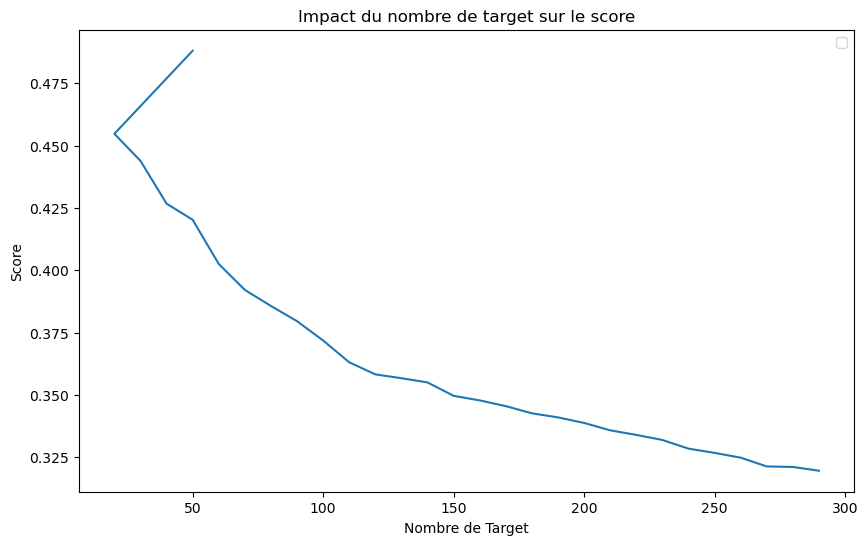

In [60]:
plt.figure(figsize=(10,6))
plt.plot(Data_Targ["Nb_targ"],Data_Targ["Jaccard"] )
plt.xlabel('Nombre de Target')
plt.ylabel('Score')
plt.title("Impact du nombre de target sur le score")
plt.legend()
plt.show()

# Milestone 5 : Proposition de mots clés – Approche supervisée Sentence embedding

Dans cette section, nous cherchons à évaluer l'effet du nombre de tags sur la performance de notre modèle.

In [58]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

from gensim.models import Word2Vec, Doc2Vec
import time



#from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, TFBertModel


In [59]:
data, docs = data_load_reshape(path)

dico_mlb = func_mlb (50)
Tags_Target = dico_mlb ["Tags_Target"]
Df_target = dico_mlb ["DataFrame"]
tags = dico_mlb ["tags"]
mlb = dico_mlb ["mlb"]

In [60]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)


## Model Use

In [70]:
import tensorflow_hub

In [72]:
def Modele_ML_Use (model,Target, Feats, b_size, Nom) :



    """
    Fonction qui donne les métrics ainsi que le modèle entrainé
    https://towardsdatascience.com/8-metrics-to-measure-classification-performance-984d9d7fd7aa
    """
    
    X_train, X_test, y_train, y_test = func_Train_Test_Split (Target, Feats)
    
    x_train=feature_USE_fct(X_train,b_size)
    x_test=feature_USE_fct(X_test,b_size)
    
    Model = model
    time_start = time.perf_counter()
    Model.fit(x_train ,y_train)
    time_end = time.perf_counter()
    y_Predict = Model.predict(x_test)

    ##cm = confusion_matrix(y_test, y_Predict)
    ##cm_display = ConfusionMatrixDisplay(cm).plot()
    ## jaccard_score 
    J_Score = jaccard_score(y_test, y_Predict, average = "micro")
    accurracy = accuracy_score(y_test, y_Predict)
   
    recall = recall_score(y_test, y_Predict, average = "micro")
    precision = precision_score(y_test, y_Predict, average = "micro")
    f1 =  f1_score(y_test, y_Predict, average = "micro")

    print(f'Entrainement du modèle : {Nom}\n')
    print(f' Jaccqaurd score = {J_Score} ')

    model_resume = {
                    'Model':[Nom],
                    'Jaccard' : [J_Score],
                    'accuracy' : [accurracy],
                    'recall': [recall],
                    'precision' : [precision],
                    'f1':[f1],
                    'fit time' : [time_end - time_start]

                   }
    

    Df_model = pd.DataFrame(model_resume)
   
    return  model_resume, Model, Df_model

In [71]:
import tensorflow_hub as hub

In [68]:
import tensorflow as tf

def load_saved_model(model_path):
    """
    Charge un modèle TensorFlow enregistré au format SavedModel.

    Args:
        model_path (str): Le chemin d'accès complet vers le dossier contenant le modèle SavedModel.

    Returns:
        loaded_model (tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject): Le modèle chargé à partir du chemin d'accès spécifié.

    Raises:
        ValueError: Si le chemin d'accès spécifié ne contient pas de modèle SavedModel valide.
    """
    try:
        loaded_model = tf.saved_model.load(model_path)
        return loaded_model
    except ValueError as e:
        raise ValueError("Le chemin d'accès spécifié ne contient pas de modèle SavedModel valide.")
        

model_path =r"C:\Users\cedri\OneDrive\Documents\Cours\OpenClassroom\Cours\Projet_5"


embed = load_saved_model(model_path)

In [73]:
# Load BERT from the Tensorflow Hub
import tensorflow_hub as hub


def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))
            
    return features

In [74]:
batch_size = 10
sentences = data["Title + Body"].astype(str)
features_USE = feature_USE_fct(sentences, batch_size)
X = features_USE

In [76]:
Model_LR= OneVsRestClassifier(LogisticRegression(random_state = 1))
Model_LR_resume_USE, Model_LR_Trained_Use, DF_LR_Use = Modele_ML (Model_LR,Tags_Target, X, "Model Logistic Regression","Use")

Data_add = pd.DataFrame (data = Model_LR_resume_USE)
Data_Synthèse = Data_Synthèse.append(Data_add)
Data_Synthèse

Entrainement du modèle : Model Logistic Regression

 jaccard score = 0.4609110302421885 


,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,83.330092
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,224.392075
0,Model SGD,TF IDF,0.488060,0.533682,0.541216,0.832476,0.655968,34.152372
0,Model SGD,Vectorizer,0.420233,0.414153,0.603218,0.580769,0.591780,152.779223
0,Model PAC,TF IDF,0.453161,0.433151,0.637386,0.610569,0.623690,107.161999
0,Model PAC,Vectorizer,0.418415,0.403942,0.614607,0.567243,0.589976,129.307243
0,Model Logistic Regression,Use,0.433632,0.448191,0.565561,0.650217,0.604942,227.778593
0,Model SGD,Use,0.420233,0.414153,0.603218,0.580769,0.591780,180.013873
0,Model PAC,Use,0.418415,0.403942,0.614607,0.567243,0.589976,128.994937
0,Model Logistic Regression,Use,0.460911,0.511517,0.522921,0.795366,0.630991,18.932030


In [77]:
Model_SGD_resume_USE, Model_SGD_Trained_Use, DF_SGD_Use = Modele_ML (SGD_Model,Tags_Target, X, "Model SGD","Use")
Data_add = pd.DataFrame (data = Model_SGD_resume_USE)
Data_Synthèse = Data_Synthèse.append(Data_add)
Data_Synthèse

Entrainement du modèle : Model SGD

 jaccard score = 0.4604416403785489 


,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,83.330092
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,224.392075
0,Model SGD,TF IDF,0.488060,0.533682,0.541216,0.832476,0.655968,34.152372
0,Model SGD,Vectorizer,0.420233,0.414153,0.603218,0.580769,0.591780,152.779223
0,Model PAC,TF IDF,0.453161,0.433151,0.637386,0.610569,0.623690,107.161999
0,Model PAC,Vectorizer,0.418415,0.403942,0.614607,0.567243,0.589976,129.307243
0,Model Logistic Regression,Use,0.433632,0.448191,0.565561,0.650217,0.604942,227.778593
0,Model SGD,Use,0.420233,0.414153,0.603218,0.580769,0.591780,180.013873
0,Model PAC,Use,0.418415,0.403942,0.614607,0.567243,0.589976,128.994937
0,Model Logistic Regression,Use,0.460911,0.511517,0.522921,0.795366,0.630991,18.932030


In [78]:
Model_PAC_resume_USE, Model_PAC_Trained_Use, DF_PAC_Use = Modele_ML (PAC_Model,Tags_Target, X, "Model PAC","Use")
Data_add = pd.DataFrame (Model_PAC_resume_USE)
Data_Synthèse = Data_Synthèse.append(Data_add)
Data_Synthèse

Entrainement du modèle : Model PAC

 jaccard score = 0.42205842205842203 


,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,83.330092
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,224.392075
0,Model SGD,TF IDF,0.488060,0.533682,0.541216,0.832476,0.655968,34.152372
0,Model SGD,Vectorizer,0.420233,0.414153,0.603218,0.580769,0.591780,152.779223
0,Model PAC,TF IDF,0.453161,0.433151,0.637386,0.610569,0.623690,107.161999
0,Model PAC,Vectorizer,0.418415,0.403942,0.614607,0.567243,0.589976,129.307243
0,Model Logistic Regression,Use,0.433632,0.448191,0.565561,0.650217,0.604942,227.778593
0,Model SGD,Use,0.420233,0.414153,0.603218,0.580769,0.591780,180.013873
0,Model PAC,Use,0.418415,0.403942,0.614607,0.567243,0.589976,128.994937
0,Model Logistic Regression,Use,0.460911,0.511517,0.522921,0.795366,0.630991,18.932030


# Word2VEC

In [79]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [80]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data["Title + Body T2N"].astype(str).to_list()
#sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [81]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 145605
Word2Vec trained


In [82]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 145606


In [83]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (145606, 300)


In [84]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 300)           43681800  
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 43,681,800
Trainable params: 43,681,800
Non-trainable params: 0
_________________________________________________________________


In [85]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

1316/1316 [==============================] - 1s 884us/step


(42110, 300)

In [86]:
X = embeddings

In [87]:
Model_LR_resume_W2V, Model_LR_Trained_W2V, DF_LR_W2V = Modele_ML (Model_LR,Tags_Target, X, "Model Logistic Regression","Word 2Wec")
Data_add = pd.DataFrame (data = Model_LR_resume_W2V)
Data_Synthèse = Data_Synthèse.append(Data_add)

Model_SGD_resume_W2V, Model_SGD_Trained_W2V, DF_SGD_W2V = Modele_ML (SGD_Model,Tags_Target, X, "Model SGD","Word 2Wec")
Data_add = pd.DataFrame (data = Model_SGD_resume_W2V)
Data_Synthèse = Data_Synthèse.append(Data_add)

Model_PAC_resume_W2V, Model_PAC_Trained_W2V, DF_PAC_W2V = Modele_ML (PAC_Model,Tags_Target, X, "Model PAC","Word 2Wec")
Data_add = pd.DataFrame (Model_PAC_resume_W2V)
Data_Synthèse = Data_Synthèse.append(Data_add)
Data_Synthèse

Entrainement du modèle : Model Logistic Regression

 jaccard score = 0.34067404793770534 
Entrainement du modèle : Model SGD

 jaccard score = 0.3311758978177444 
Entrainement du modèle : Model PAC

 jaccard score = 0.2729801140314282 


,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,83.330092
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,224.392075
0,Model SGD,TF IDF,0.488060,0.533682,0.541216,0.832476,0.655968,34.152372
0,Model SGD,Vectorizer,0.420233,0.414153,0.603218,0.580769,0.591780,152.779223
0,Model PAC,TF IDF,0.453161,0.433151,0.637386,0.610569,0.623690,107.161999
0,Model PAC,Vectorizer,0.418415,0.403942,0.614607,0.567243,0.589976,129.307243
0,Model Logistic Regression,Use,0.433632,0.448191,0.565561,0.650217,0.604942,227.778593
0,Model SGD,Use,0.420233,0.414153,0.603218,0.580769,0.591780,180.013873
0,Model PAC,Use,0.418415,0.403942,0.614607,0.567243,0.589976,128.994937
0,Model Logistic Regression,Use,0.460911,0.511517,0.522921,0.795366,0.630991,18.932030


In [88]:
Data_Synthèse

,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,83.330092
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,224.392075
0,Model SGD,TF IDF,0.488060,0.533682,0.541216,0.832476,0.655968,34.152372
0,Model SGD,Vectorizer,0.420233,0.414153,0.603218,0.580769,0.591780,152.779223
0,Model PAC,TF IDF,0.453161,0.433151,0.637386,0.610569,0.623690,107.161999
0,Model PAC,Vectorizer,0.418415,0.403942,0.614607,0.567243,0.589976,129.307243
0,Model Logistic Regression,Use,0.433632,0.448191,0.565561,0.650217,0.604942,227.778593
0,Model SGD,Use,0.420233,0.414153,0.603218,0.580769,0.591780,180.013873
0,Model PAC,Use,0.418415,0.403942,0.614607,0.567243,0.589976,128.994937
0,Model Logistic Regression,Use,0.460911,0.511517,0.522921,0.795366,0.630991,18.932030


# **Modélisation with BERT**

Comme la méthode Bert nécessite beaucoup de ressources, nous allons utiliser un petit échantillon de données pour tester cette méthode.

In [2]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import os
import transformers

os.environ["TF_KERAS"]='1'

In [106]:
from transformers import AutoTokenizer

In [95]:
data, docs = data_load_reshape(path)

dico_mlb = func_mlb (50)
Tags_Target = dico_mlb ["Tags_Target"]
Df_target = dico_mlb ["DataFrame"]
tags = dico_mlb ["tags"]
mlb = dico_mlb ["mlb"]

In [96]:
sentences = data["Title + Body"].astype(str).to_list()

In [97]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [100]:
model_path =r"C:\Users\cedri\OneDrive\Documents\Cours\OpenClassroom\Cours\Projet_5\Nouveau dossier"


model_url = load_saved_model(model_path)

In [101]:
import tensorflow_hub as hub
# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
#model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [102]:
sentences = data["Title + Body"][:2000].astype(str).tolist()
Tags_Target_ = Tags_Target.copy() 
Tags_Target = Tags_Target[:2000]

In [103]:
len(Tags_Target)

2000

In [107]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\cedri/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\cedri/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

temps traitement :  192.0


In [108]:
X = features_bert

In [109]:
Model_LR= OneVsRestClassifier(LogisticRegression(random_state = 1))
PAC_Model = OneVsRestClassifier(PassiveAggressiveClassifier(random_state = 1))
SGD_Model = OneVsRestClassifier(SGDClassifier(random_state = 1))

Model_LR_resume_Bert, Model_LR_Trained_Bert, DF_LR_Bert = Modele_ML (Model_LR,Tags_Target, X, "Model Logistic Regression","Bert")
Data_add = pd.DataFrame (data = Model_LR_resume_Bert)
Data_Synthèse = Data_Synthèse.append(Data_add)

Model_SGD_resume_Bert, Model_SGD_Trained_Bert, DF_SGD_Bert = Modele_ML (SGD_Model,Tags_Target, X, "Model SGD","Bert")
Data_add = pd.DataFrame (data = Model_SGD_resume_Bert)
Data_Synthèse = Data_Synthèse.append(Data_add)

Model_PAC_resume_Bert, Model_PAC_Trained_Bert, DF_PAC_Bert = Modele_ML (PAC_Model,Tags_Target, X, "Model PAC","Bert")
Data_add = pd.DataFrame (Model_PAC_resume_Bert)
Data_Synthèse = Data_Synthèse.append(Data_add)
Data_Synthèse

Entrainement du modèle : Model Logistic Regression

 jaccard score = 0.18046132971506107 
Entrainement du modèle : Model SGD

 jaccard score = 0.2176560121765601 
Entrainement du modèle : Model PAC

 jaccard score = 0.2354014598540146 


,Model,Features Traitement,Jaccard,accuracy,recall,precision,f1,fit time
0,Model Logistic Regression,TF IDF,0.450950,0.509459,0.500000,0.821328,0.621593,83.330092
0,Model Logistic Regression,Vectorizer,0.433632,0.448191,0.565561,0.650217,0.604942,224.392075
0,Model SGD,TF IDF,0.488060,0.533682,0.541216,0.832476,0.655968,34.152372
0,Model SGD,Vectorizer,0.420233,0.414153,0.603218,0.580769,0.591780,152.779223
0,Model PAC,TF IDF,0.453161,0.433151,0.637386,0.610569,0.623690,107.161999
0,Model PAC,Vectorizer,0.418415,0.403942,0.614607,0.567243,0.589976,129.307243
0,Model Logistic Regression,Use,0.433632,0.448191,0.565561,0.650217,0.604942,227.778593
0,Model SGD,Use,0.420233,0.414153,0.603218,0.580769,0.591780,180.013873
0,Model PAC,Use,0.418415,0.403942,0.614607,0.567243,0.589976,128.994937
0,Model Logistic Regression,Use,0.460911,0.511517,0.522921,0.795366,0.630991,18.932030


Nous avons choisi le modèle SGD Classifier avec la méthode de vectorisation TF-IDF pour notre modèle de prédiction de tags. Nous avons sauvegardé ce modèle pour une utilisation future.

#  Enregistrement Modèle

In [110]:
import pickle

# nom du modèle à enregistrer
model_name = "Modele SGD Tf IDF.pkl"

# entraînement du modèle ici...

# enregistrer le modèle à l'aide de pickle
with open(model_name, 'wb') as file:
    pickle.dump(Model_SGD_Trained, file)